In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, assemble, execute
from qiskit.visualization import plot_histogram
import matplotlib as plt
import numpy as np
import torch
from torch.autograd import Variable

In [2]:
# constants for the structure of the circuit
number_of_qubits = 1
number_of_layers = 2

In [3]:
# input and target states initialization

#initial_state = [1,0]

target_state = [0.,1.]
target_state = Variable(
    torch.tensor(target_state),
    requires_grad=True
)

In [4]:
params = np.ones((number_of_qubits, number_of_layers, 3))
params = Variable(torch.tensor(params), requires_grad=True)
print(params)

tensor([[[1., 1., 1.],
         [1., 1., 1.]]], dtype=torch.float64, requires_grad=True)


In [5]:
# function that creates and runs the circuit with fixed parameters

def create_circuit(params_):
    
    # circuit initialization
    qr = QuantumRegister(number_of_qubits)
    cr = ClassicalRegister(number_of_qubits)

    circuit = QuantumCircuit(qr, cr)

    #circuit.initialize(_initial_state)
    #circuit.barrier()
    
    # layers definition
    for j in range(number_of_layers):
        for i in range(number_of_qubits):
            circuit.rx(params_[i, j, 0].item(), i)
            circuit.ry(params_[i, j, 1].item(), i)
            circuit.rz(params_[i, j, 2].item(), i)
            
            for k in range(i+1, number_of_qubits):
                circuit.cx(i, k)

            circuit.barrier()
    
    
    #for i in range(number_of_qubits):
        #circuit.measure(i, i)
    
    circuit.measure(0,0)

    return circuit

In [6]:
# function to retrive the uotput state amplitudes

def get_amplitudes(circuit_):
    
    aer_sim = Aer.get_backend('aer_simulator')
    qobj = assemble(circuit_, shots=1000)
    results = aer_sim.run(qobj).result()
    amplitudes = results.data()
    
    return amplitudes

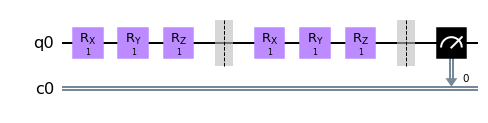

In [7]:
circuit = create_circuit(params)
circuit.draw(output='mpl')

In [8]:
# starting with linear cost function, minimize the difference between each amplitude
def amplitudes_cost(circuit_):

    cost = 0.
    amplitudes = list(get_amplitudes(circuit)['counts'].values())
    amplitudes = np.array(amplitudes)
    amplitudes = amplitudes/np.sqrt(np.sum(amplitudes**2))


    for i in range(len(amplitudes)):
        cost += torch.abs(amplitudes[i] - torch.abs(target_state[i]))

    return cost

tensor(1.8398, grad_fn=<AddBackward0>)
Cost after 0 steps is 0.1500
Cost after 1 steps is 0.1274
Cost after 2 steps is 0.1647
Cost after 3 steps is 0.1573
Cost after 4 steps is 0.1414
Cost after 5 steps is 0.1677
Cost after 6 steps is 0.1302
Cost after 7 steps is 0.1302
Cost after 8 steps is 0.1414
Cost after 9 steps is 0.1515
Cost after 10 steps is 0.1400
Cost after 11 steps is 1.8412
Cost after 12 steps is 0.1400
Cost after 13 steps is 1.8442
Cost after 14 steps is 0.1233
Cost after 15 steps is 0.1486
Cost after 16 steps is 0.1573
Cost after 17 steps is 0.1632
Cost after 18 steps is 0.1617
Cost after 19 steps is 0.1588
Cost after 20 steps is 0.1515
Cost after 21 steps is 1.8529
Cost after 22 steps is 1.8670
Cost after 23 steps is 0.1602
Cost after 24 steps is 1.8338
Cost after 25 steps is 0.1558
Cost after 26 steps is 0.1632
Cost after 27 steps is 0.1588
Cost after 28 steps is 0.1179
Cost after 29 steps is 1.8248
Cost after 30 steps is 0.1457
Cost after 31 steps is 0.1220
Cost after 

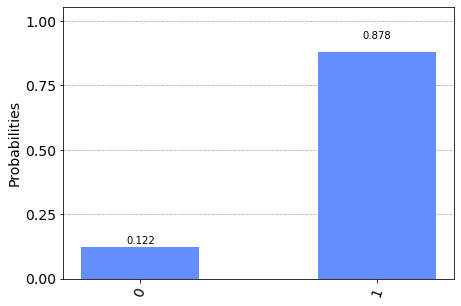

In [9]:

# set up the optimizer
opt = torch.optim.Adam([params], lr=1000)

# number of steps in the optimization routine
steps = 200

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = amplitudes_cost(create_circuit(params))
best_params = np.zeros((number_of_qubits, number_of_layers, 3))

print(best_cost)

print("Cost after 0 steps is {:.4f}".format(amplitudes_cost(create_circuit(params))))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    q_circuit = create_circuit(params)
    loss = amplitudes_cost(q_circuit)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    #if n % 10 == 9 or n == steps - 1:
    print("Cost after {} steps is {:.4f}".format(n + 1, loss))
        #print(params)

# calculate the Bloch vector of the output state

q_circuit = create_circuit(best_params)
q_circuit.save_statevector()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(q_circuit, shots=1000)
results = aer_sim.run(qobj).result()
output_state = results.data()

# print results
print("Target vector = ", target_state)
print("Output vector = ", output_state)
plot_histogram(results.get_counts())

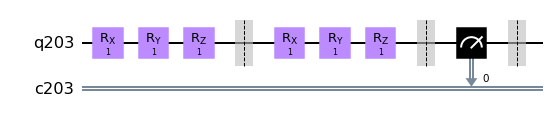

In [10]:
q_circuit.draw(output='mpl')

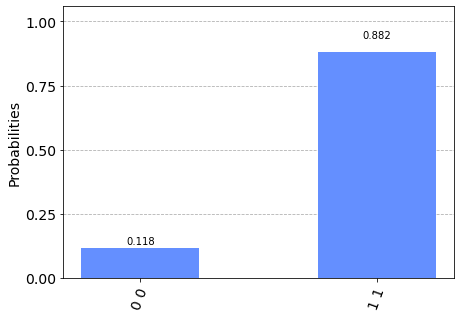

In [13]:
q_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(q_circuit, shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [12]:
params

tensor([[[1., 1., 1.],
         [1., 1., 1.]]], dtype=torch.float64, requires_grad=True)